## 1. Цель лабораторной работы:
Изучение разработки рекомендательных моделей.

## 2. Задание:
1. Выбрать произвольный набор данных (датасет), предназначенный для построения рекомендательных моделей.
2. Опираясь на материалы лекции, сформировать рекомендации для одного пользователя (объекта) двумя произвольными способами.
3. Сравнить полученные рекомендации (если это возможно, то с применением метрик).

## 3. Ход выполнения работы

Импорт библиотек

In [4]:
import numpy as np
import pandas as pd
from typing import Dict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from surprise import SVD, Dataset, Reader
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline 
sns.set(style="ticks")

Чтение данных

In [116]:
df_anime_all=pd.read_csv('anime.csv')

In [117]:
df_anime_all.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [118]:
df_anime_all.shape

(12294, 7)

In [119]:
df_rating=pd.read_csv('rating.csv')
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [120]:
df_rating.shape

(7813737, 3)

In [121]:
# Оставляем только аниме, которые есть в df_rating
anime_ids = df_rating[df_rating['anime_id'].notnull()]['anime_id']
df_anime = df_anime_all[df_anime_all['anime_id'].isin(anime_ids)]

In [122]:
df_anime_all.shape,df_anime.shape

((12294, 7), (11197, 7))

Выбор идентификаторов для связи таблиц

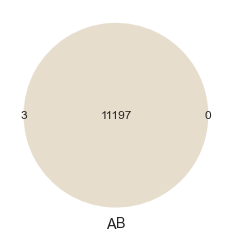

In [123]:
venn2([set(df_rating['anime_id'].unique()), set(df_anime['anime_id'].unique())])

Векторизация описания фильмов

In [124]:
df_anime_with_genre = df_anime[df_anime['genre'].notnull()]
df_anime_with_genre = df_anime_with_genre[~df_anime_with_genre['genre'].str.isspace()]

In [125]:
anime_id=df_anime_with_genre['anime_id'].values
anime_id[0:5]

array([32281,  5114, 28977,  9253,  9969], dtype=int64)

In [126]:
anime_name=df_anime_with_genre['name'].values
anime_name[0:5]

array(['Kimi no Na wa.', 'Fullmetal Alchemist: Brotherhood', 'Gintama°',
       'Steins;Gate', 'Gintama&#039;'], dtype=object)

In [127]:
genre=df_anime_with_genre['genre'].values
genre[0:5]

array(['Drama, Romance, School, Supernatural',
       'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
       'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
       'Sci-Fi, Thriller',
       'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'],
      dtype=object)

In [128]:
type=df_anime_with_genre['type'].values
type[0:5]

array(['Movie', 'TV', 'TV', 'TV', 'TV'], dtype=object)

In [129]:
%%time
tfidfv = TfidfVectorizer()
genre_matrix = tfidfv.fit_transform(genre)
genre_matrix

Wall time: 66.1 ms


<11165x47 sparse matrix of type '<class 'numpy.float64'>'
	with 38734 stored elements in Compressed Sparse Row format>

### 3.1 Фильтрация на основе содержания

Рекомендации в зависимости от жанров аниме

In [130]:
class SimpleKNNRecommender:
    
    def __init__(self, X_matrix, X_ids, X_name, X_genre, X_type):
        """
        Входные параметры:
        X_matrix - обучающая выборка (матрица объект-признак)
        X_ids - массив идентификаторов аниме
        X_name - массив названий аниме
        X_genre - массив жанров аниме
        X_type - массив типов аниме
        """
        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'id': pd.Series(X_ids, dtype='int'),
            'name': pd.Series(X_name, dtype='str'),
            'genre': pd.Series(X_genre, dtype='str'),
            'type':pd.Series(X_type,dtype='str'),
            'dist': pd.Series([], dtype='float')})
            
            
    def recommend_for_single_object(self, K: int, \
                X_matrix_object, cos_flag = True, manh_flag = False):
        """
        Метод формирования рекомендаций для одного объекта.
        Входные параметры:
        K - количество рекомендуемых соседей 
        X_matrix_object - строка матрицы объект-признак, соответствующая объекту
        cos_flag - флаг вычисления косинусного расстояния
        manh_flag - флаг вычисления манхэттэнского расстояния
        Возвращаемое значение: K найденных соседей
        """
        
        scale = 1000000
        # Вычисляем косинусную близость
        if cos_flag:
            dist = cosine_similarity(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=False)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] < scale]
        
        else:
            if manh_flag:
                dist = manhattan_distances(self._X_matrix, X_matrix_object)
            else:
                dist = euclidean_distances(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=True)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] > 0.0]            
        
        # Оставляем К первых рекомендаций
        res = res.head(K)
        return res

In [131]:
你的名字 = 0
anime_name[你的名字]

'Kimi no Na wa.'

In [132]:
genre[你的名字]

'Drama, Romance, School, Supernatural'

In [21]:
你的名字_matrix=genre_matrix[你的名字]
你的名字_matrix

<1x47 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [22]:
skr1 = SimpleKNNRecommender(genre_matrix, anime_id, anime_name, genre, type)

In [23]:
rec1 = skr1.recommend_for_single_object(15, 你的名字_matrix)
rec1

,id,name,genre,type,dist
1089,14669,Aura: Maryuuin Kouga Saigo no Tatakai,"Comedy, Drama, Romance, School, Supernatural",Movie,955003.572763
1177,10067,Angel Beats!: Another Epilogue,"Drama, School, Supernatural",Special,874531.136996
1465,20903,Harmonie,"Drama, School, Supernatural",Movie,874531.136996
860,2787,Shakugan no Shana II (Second),"Action, Drama, Fantasy, Romance, School, Super...",TV,868452.470792
1573,6572,Shakugan no Shana S,"Action, Drama, Fantasy, Romance, School, Super...",OVA,868452.470792
968,355,Shakugan no Shana,"Action, Drama, Fantasy, Romance, School, Super...",TV,868452.470792
4442,2105,Touka Gettan,"Drama, Romance, Supernatural",TV,853905.126056
4952,1039,Mizuiro (2003),"Drama, Romance, Supernatural",OVA,853905.126056
5046,1607,Venus Versus Virus,"Drama, Romance, Supernatural",TV,853905.126056
1925,713,Air Movie,"Drama, Romance, Supernatural",Movie,853905.126056


In [24]:
rec2 = skr1.recommend_for_single_object(15, 你的名字_matrix, cos_flag = False)
rec2

,id,name,genre,type,dist
1089,14669,Aura: Maryuuin Kouga Saigo no Tatakai,"Comedy, Drama, Romance, School, Supernatural",Movie,299988.090553
1465,20903,Harmonie,"Drama, School, Supernatural",Movie,500936.848323
1177,10067,Angel Beats!: Another Epilogue,"Drama, School, Supernatural",Special,500936.848323
1573,6572,Shakugan no Shana S,"Action, Drama, Fantasy, Romance, School, Super...",OVA,512927.927116
860,2787,Shakugan no Shana II (Second),"Action, Drama, Fantasy, Romance, School, Super...",TV,512927.927116
968,355,Shakugan no Shana,"Action, Drama, Fantasy, Romance, School, Super...",TV,512927.927116
5046,1607,Venus Versus Virus,"Drama, Romance, Supernatural",TV,540545.787042
4442,2105,Touka Gettan,"Drama, Romance, Supernatural",TV,540545.787042
1925,713,Air Movie,"Drama, Romance, Supernatural",Movie,540545.787042
4952,1039,Mizuiro (2003),"Drama, Romance, Supernatural",OVA,540545.787042


In [25]:
rec3 = skr1.recommend_for_single_object(15, 你的名字_matrix, 
                                        cos_flag = False, manh_flag = True)
rec3

,id,name,genre,type,dist
1089,14669,Aura: Maryuuin Kouga Saigo no Tatakai,"Comedy, Drama, Romance, School, Supernatural",Movie,386313.304825
1177,10067,Angel Beats!: Another Epilogue,"Drama, School, Supernatural",Special,701457.461391
1465,20903,Harmonie,"Drama, School, Supernatural",Movie,701457.461391
4952,1039,Mizuiro (2003),"Drama, Romance, Supernatural",OVA,772527.740002
4442,2105,Touka Gettan,"Drama, Romance, Supernatural",TV,772527.740002
5046,1607,Venus Versus Virus,"Drama, Romance, Supernatural",TV,772527.740002
1925,713,Air Movie,"Drama, Romance, Supernatural",Movie,772527.740002
6061,2179,Tokimeki Memorial: Forever With You,"Drama, Romance, School",OVA,826581.218191
6057,756,School Days ONA,"Drama, Romance, School",ONA,826581.218191
3839,18053,Koi to Senkyo to Chocolate: Ikenai Hazuki-sensei,"Drama, Romance, School",Special,826581.218191


Можно увидеть,все три расчета расстояния дают правильные результаты. Рекомендуемое аниме содержит ключевое слово того же жанра.

### 3.2 Коллаборативная фильтрация

In [26]:
len(df_rating['user_id'].unique())# Количество уникальных пользователей

73515

In [27]:
len(df_rating['anime_id'].unique())# Количество уникальных аниме

11200

In [28]:
def create_utility_matrix(data):
    itemField = 'anime_id'
    userField = 'user_id'
    valueField = 'rating'  
    
    userList = data[userField].tolist()
    itemList = data[itemField].tolist()
    valueList = data[valueField].tolist()    
    
    users = list(set(userList))
    items = list(set(itemList))    
    
    users_index = {users[i]: i for i in range(len(users))}    
    pd_dict = {item: [0.0 for i in range(len(users))] for item in items}    
    
    for i in range(0,data.shape[0]):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]    
        pd_dict[item][users_index[user]] = value    
    
    X = pd.DataFrame(pd_dict)
    X.index = users
        
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    
    return X, users_index, items_index

In [29]:
%%time
user_item_matrix, users_index, items_index = create_utility_matrix(df_rating)

Wall time: 2min 33s


In [30]:
user_item_matrix

,32768,1,5,6,7,8,32775,32776,32777,32778,...,32755,32756,32757,32758,32759,32761,32763,32764,32765,32767
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73513,0.0,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73515,0.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Проверьте пользователей, которые оценили аниме «你的名字»

In [133]:
print(df_rating.loc[df_rating['anime_id']==32281,['user_id','rating']])

         user_id  rating
8271          99       5
11961        152      10
19665        244      10
22985        271      10
23382        278      -1
...          ...     ...
7758439    73042       9
7763841    73099      10
7764599    73109       9
7791788    73311       7
7792479    73319       8

[2199 rows x 2 columns]


Выбрать пользователей, которые дали 10 баллов для «你的名字», в качестве тестовых объектов для рекомендательной системы.  
Выбрать user_id = 73099

In [156]:
user_item_matrix__test = user_item_matrix.loc[[73099]]
user_item_matrix__test

,32768,1,5,6,7,8,32775,32776,32777,32778,...,32755,32756,32757,32758,32759,32761,32763,32764,32765,32767
73099,0.0,10.0,10.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
user_item_matrix__train = user_item_matrix.loc[:73515]
user_item_matrix__train

,32768,1,5,6,7,8,32775,32776,32777,32778,...,32755,32756,32757,32758,32759,32761,32763,32764,32765,32767
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73513,0.0,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Построение модели на основе SVD

In [158]:
%%time
U, S, VT = np.linalg.svd(user_item_matrix__train.T)
V = VT.T

MemoryError: Unable to allocate 40.3 GiB for an array with shape (73514, 73514) and data type float64

Из-за огромного объема данных и нехватки памяти при расчете в качестве тестового набора сейчас выбрано всего 1000 групп.

In [159]:
user_item_matrix__train = user_item_matrix.loc[:1000]
user_item_matrix__train

,32768,1,5,6,7,8,32775,32776,32777,32778,...,32755,32756,32757,32758,32759,32761,32763,32764,32765,32767
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
%%time
U, S, VT = np.linalg.svd(user_item_matrix__train.T)
V = VT.T

Wall time: 5.34 s


In [161]:
U.shape# 用户和潜在因素之间的关系矩阵

(11200, 11200)

In [162]:
V.shape# 对象和潜在因素之间的关系矩阵

(1000, 1000)

In [163]:
S.shape

(1000,)

In [164]:
Sigma = np.diag(S)# 对角奇异值矩阵
Sigma.shape

(1000, 1000)

In [165]:
Sigma

array([[1.01416378e+03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.94422598e+02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.31696313e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.02223742e-14, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.02223742e-14, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 8.02223742e-14]])

In [166]:
r=3
Ur = U[:, :r]
Sr = Sigma[:r, :r]
Vr = V[:, :r]

In [167]:
# 新用户和潜在因素之间的关系矩阵
test_user = np.mat(user_item_matrix__test.values)
test_user.shape, test_user

((1, 11200), matrix([[ 0., 10., 10., ...,  0.,  0.,  0.]]))

In [168]:
tmp = test_user * Ur * np.linalg.inv(Sr)
tmp

matrix([[ 0.0776233 , -0.01761988, -0.06338172]])

In [169]:
test_user_result = np.array([tmp[0,0], tmp[0,1], tmp[0,2]])
test_user_result

array([ 0.0776233 , -0.01761988, -0.06338172])

In [170]:
cos_sim = cosine_similarity(Vr, test_user_result.reshape(1, -1))
cos_sim[:10]

array([[-0.40546416],
       [ 0.35577201],
       [ 0.84163232],
       [ 0.00909248],
       [ 0.94357332],
       [ 0.09480675],
       [ 0.45676532],
       [-0.35388716],
       [ 0.51941178],
       [-0.0445435 ]])

In [171]:
cos_sim_list = cos_sim.reshape(-1, cos_sim.shape[0])[0]
cos_sim_list[:10]

array([-0.40546416,  0.35577201,  0.84163232,  0.00909248,  0.94357332,
        0.09480675,  0.45676532, -0.35388716,  0.51941178, -0.0445435 ])

In [172]:
recommended_user_id = np.argsort(-cos_sim_list)[0]
recommended_user_id

349

In [173]:
anime_list = list(user_item_matrix.columns)
def anime_recommend(ind):
    try:
        anime_id = anime_list[ind]
        flt_rating = df_rating[df_rating['anime_id'] == anime_id]
        rating = flt_rating['anime_id'].values[0]
        anime_rating = df_anime[df_anime['anime_id'] == rating]
        res = anime_rating['name'].values[0]
        return res
    except:
        return '' 

In [180]:
# Аниме, которые оценивал текущий пользователь user_id=152:
i=1
for idx, item in enumerate(np.ndarray.flatten(np.array(test_user))):
    if item > 0:
        anime_name = anime_recommend(idx)
        print('{} - {} - {}'.format(idx, anime_name, item))
        if i==20:
            break
        else:
            i+=1

1 - Cowboy Bebop - 10.0
2 - Cowboy Bebop: Tengoku no Tobira - 10.0
3 - Trigun - 9.0
15 - Initial D Fourth Stage - 7.0
16 - Monster - 7.0
21 - School Rumble - 5.0
27 - Neon Genesis Evangelion - 7.0
29 - Neon Genesis Evangelion: The End of Evangelion - 8.0
37 - Ghost in the Shell - 9.0
39 - Rurouni Kenshin: Meiji Kenkaku Romantan - 7.0
53 - Chobits - 7.0
60 - Azumanga Daioh - 7.0
65 - Full Metal Panic! - 8.0
66 - Full Metal Panic? Fumoffu - 8.0
67 - Full Metal Panic! The Second Raid - 8.0
70 - Mahou Shoujo Lyrical Nanoha - 7.0
71 - Mahou Shoujo Lyrical Nanoha A&#039;s - 7.0
73 - Shuffle! - 7.0
91 - Last Exile - 7.0
95 - Air - 7.0


In [178]:
# Аниме, которые оценивал наиболее схожий пользователь:
i=1
recommended_user_item_matrix = user_item_matrix.loc[[recommended_user_id+1]]
for idx, item in enumerate(np.ndarray.flatten(np.array(recommended_user_item_matrix))):
    if item > 0:
        anime_name = anime_recommend(idx)
        print('{} - {} - {}'.format(idx, anime_name, item))
        if i==20:
            break
        else:
            i+=1

16 - Monster - 8.0
27 - Neon Genesis Evangelion - 9.0
29 - Neon Genesis Evangelion: The End of Evangelion - 8.0
37 - Ghost in the Shell - 8.0
430 - Perfect Blue - 8.0
821 - Suzumiya Haruhi no Yuuutsu - 8.0
1282 - Danganronpa 3: The End of Kibougamine Gakuen - Kibou-hen - 8.0
1419 - Shelter - 8.0
1480 - Death Note - 9.0
1520 - Code Geass: Hangyaku no Lelouch - 8.0
1629 - Byousoku 5 Centimeter - 7.0
1871 - Paprika - 8.0
1922 - Tengen Toppa Gurren Lagann - 10.0
1945 - Darker than Black: Kuro no Keiyakusha - 8.0
2085 - Clannad - 8.0
2150 - Toki wo Kakeru Shoujo - 8.0
2491 - Kara no Kyoukai 1: Fukan Fuukei - 7.0
2655 - Evangelion: 1.0 You Are (Not) Alone - 9.0
2773 - Code Geass: Hangyaku no Lelouch R2 - 10.0
3430 - Evangelion: 2.0 You Can (Not) Advance - 9.0
